In [1]:
import numpy as np
import pandas as pa
import pickle
import librosa.display

from src.utils import get_framed_label, train_test_split, from_boolean_array_to_intervals, get_annotated_intervals
from src.data import load_annotation
from src.data import load_radar, load_water_distance, load_weight_sensor, load_audio
from src import make_dataset

from matplotlib import pyplot as plt

In [2]:
config = {
    'USE_IDS': [],
    'DATAFRAME_PATH': "C:/Users/Jiajun/Desktop/download-project/data/raw/data_frames",
    'ANNOTATION_PATH': "C:/Users/Jiajun/Desktop/download-project/data/processed/Annotation.csv",
    'FEATURE_NAMES': ['Max', 'Min', 'Mean', 'Median', 'LogVariance', 'LinearTrend'],
    'SOURCE_NAMES': ['RadarSum'],
    'WINDOW_SECONDS': 3,
    'HOP_SECONDS': 1,
    'CATEGORY': "Defecation",
}

complete_ids = load_annotation.get_complete_ids(
    annotation_filename = config['ANNOTATION_PATH'],
    category = config['CATEGORY']
)

annotations = load_annotation.get_annotation(config['ANNOTATION_PATH'])

In [31]:
selected_ids = complete_ids[complete_ids < 1900]

In [32]:
TRAIN_IDS, TEST_IDS = train_test_split(selected_ids)

print(f"Category: {config['CATEGORY']}")
print(f"Training {len(TRAIN_IDS)} use_ids: {TRAIN_IDS[:5]}...")
print(f"Testing  {len(TEST_IDS)} use_ids: {TEST_IDS[:5]}...")

Category: Defecation
Training 37 use_ids: [934, 928, 976, 964, 1830]...
Testing  10 use_ids: [1802, 1854, 1870, 1875, 1882]...


In [33]:
train_config = config.copy()
test_config = config.copy()

train_config['USE_IDS'] = TRAIN_IDS#[987, 960, 954, 964, 968, 979, 976, 993, 953, 982, 984, 995, 985, 958]#TRAIN_IDS
test_config['USE_IDS'] = TEST_IDS#[989, 970, 971, 986, 978, 992]#TEST_IDS

dataset = {}
dataset['train'] = make_dataset.RandomForestDataset(train_config)
dataset['test'] = make_dataset.RandomForestDataset(test_config)

In [34]:
train_x, train_y = dataset['train'].get_features_and_labels_from_users()
test_x, test_y = dataset['test'].get_features_and_labels_from_users()

updating 934
updating 928
updating 976
updating 964
updating 1830
updating 1831
updating 947
updating 954
updating 986
updating 938
updating 993
updating 968
updating 987
updating 958
updating 930
updating 960
updating 941
updating 926
updating 1893
updating 971
updating 989
updating 982
updating 1839
updating 942
updating 1898
updating 1881
updating 979
updating 948
updating 953
updating 978
updating 995
updating 992
updating 936
updating 1862
updating 1863
updating 985
updating 1806
updating 1802
updating 1854
updating 1870
updating 1875
updating 1882
updating 1890
updating 922
updating 924
updating 970
updating 984


In [35]:
print(f'train_x.shape = {train_x.shape}, test_x.shape = {test_x.shape}')
print(f'train_y: {train_y.sum()}/{train_y.shape[0]}')
print(f'test_y : {test_y.sum()}/{test_y.shape[0]}')

train_x.shape = (6327, 6), test_x.shape = (1758, 6)
train_y: 251/6327
test_y : 61/1758


## RandomForest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_roc_curve

In [37]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=10)

In [38]:
def classification_result(model, testX, testY, threshold = 0.5):
    testYPredProb = model.predict_proba(testX)
    testYPred = (testYPredProb[:, 1] > threshold).astype(int)
    print (f"threshold = {threshold}", "\n")
    print (classification_report(testY, testYPred))

    
def variable_importance(trainX, model, top=30):
    top = min(top, trainX.shape[1])
    plt.figure(figsize=(20, 5))
    plt.bar(x = range(top), height = model.feature_importances_[:top])
    xticks_pos = np.arange(top)
    plt.xticks(xticks_pos, trainX.columns[:top], rotation=45, ha='right')
    pass

In [39]:
classification_result(
    rf,
    test_x, test_y,
    threshold = 0.3
)

threshold = 0.3 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1697
           1       0.72      0.77      0.75        61

    accuracy                           0.98      1758
   macro avg       0.86      0.88      0.87      1758
weighted avg       0.98      0.98      0.98      1758



In [46]:
classification_result(
    rf,
    test_x, test_y,
    threshold = 0.2
)

threshold = 0.2 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1697
           1       0.69      0.89      0.78        61

    accuracy                           0.98      1758
   macro avg       0.84      0.94      0.88      1758
weighted avg       0.99      0.98      0.98      1758



In [47]:
def plot_radar_with_annotation(use_i, category='Defecation'):
    intervals = get_annotated_intervals(use_i, annotations, category)
    radar = load_radar.get_radar_sum_clean(use_i)
    
    plt.figure(figsize=(10,2))
    plt.plot(radar)
    for interval in intervals:
        plt.axvspan(interval[0], interval[1], color="orange")
    plt.show()

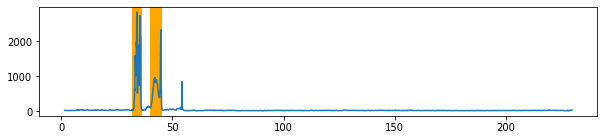

In [48]:
plot_radar_with_annotation(2055)